In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
trait_renaming = pd.read_csv(
    "../../results/gwas_gokcen/raw/disease_list.txt", delim_whitespace=True, header=None,
    names=["trait", "source", "name"]
).set_index("trait")["name"].to_dict()
trait_renaming

{'AD': 'alzheimers_disease',
 'ADHD': 'attention_deficit_hyperactivity_disorder',
 'AIT': 'autoimmune_disease',
 'ASM': 'asthma',
 'BMD-HT': 'bone_mineral_density',
 'BMI': 'body_mass_index',
 'BP': 'bipolar_disorder',
 'Breast_cancer': 'breast_cancer',
 'CAD': 'coronary_artery_disease',
 'CD': 'crohns_disease',
 'Celiac': 'celiac',
 'CVD': 'cardiovascular_disease',
 'ECOL': 'college_educatiojn',
 'Eczema': 'eczema',
 'EY': 'years_education',
 'FG': 'fasting_glucose',
 'Glucose': 'glucose',
 'HbA1c': 'hba1c',
 'HDL': 'hdl',
 'Height': 'height',
 'HT': 'hypothyroidism',
 'HTN': 'hypertension',
 'IBD': 'inflammatory_bowel_disease',
 'Insomnia': 'insomnia',
 'Intel': 'intelligence',
 'LDL': 'ldl',
 'MCH': 'mean_corpuscular_hemoglobin',
 'MDD': 'major_depressive_disorder',
 'MNP': 'morning_person',
 'MNR': 'age_of_menarche',
 'MS': 'multiple_sclerosis',
 'NRT': 'neuroticism',
 'PLT': 'platelet_count',
 'RA': 'rheumatoid_arthritis',
 'RBC': 'red_count',
 'RDW': 'red_blood_cell_width',
 'RR-

In [3]:
exclude_traits = [
    "SWB",
    "SCZ",
    "MDD",
    "BP",
    "SLE",
    "RA",
    "NRT",
    "Celiac",
    "Insomnia",
    "DHD",	
    "Celiac",
    "Insomnia",
    "ADHD",
]

traits = [trait for trait in trait_renaming.keys() if trait not in exclude_traits]

models = [
    "Enformer_L2",
    "Borzoi_L2",
    "CADD",
    "GPN-MSA",
]

palette = {model: f"C{i}" for i, model in enumerate(models)}

dfs = []
n_hits = {}

for trait in tqdm(traits):
    base_dir = f"../../results/dataset/gwas_gokcen_{trait}_matched_9_nonexonic/"
    n_hits[trait] = len(pd.read_parquet(base_dir + "test.parquet")) // 10
    for model in models:
        df = pd.read_csv(base_dir + f"metrics_by_chrom_weighted_average/{model}.BestFeature.chrom.csv")
        df.Model = df.Model.str.split(".").str[0]
        df["trait"] = trait
        dfs.append(df)
df = pd.concat(dfs)
df["n_hits"] = df.trait.map(n_hits)
df

  0%|                                                                    | 0/34 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 38.66it/s]


,Model,AUPRC,trait,n_hits
0,Enformer_L2,0.121652,AD,10
0,Borzoi_L2,0.338235,AD,10
0,CADD,0.437859,AD,10
0,GPN-MSA,0.184432,AD,10
0,Enformer_L2,0.354396,AIT,7
...,...,...,...,...
0,GPN-MSA,0.206799,TG,119
0,Enformer_L2,0.461391,WHR,57
0,Borzoi_L2,0.312091,WHR,57
0,CADD,0.428214,WHR,57


In [12]:
df.groupby("Model").AUPRC.mean().sort_values(ascending=False)

Model
Enformer_L2    0.361953
Borzoi_L2      0.341002
CADD           0.317764
GPN-MSA        0.280088
Name: AUPRC, dtype: float64

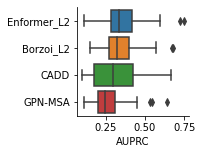

In [4]:
plt.figure(figsize=(2,2))
g = sns.boxplot(
    data=df,
    y="Model",
    x="AUPRC",
    order=df.groupby("Model").AUPRC.median().sort_values(ascending=False).index,
    palette=palette,
)
g.set(
    ylabel="",
)
sns.despine();

In [5]:
#plt.figure(figsize=(2,2))
#g = sns.boxplot(
#    data=best.query('n_hits >= 30'),
#    y="model",
#    x="AUPRC",
#    order=best.query('n_hits >= 30').groupby("model").AUPRC.median().sort_values(ascending=False).index,
#    palette=palette,
#)
#g.set(
#    ylabel="",
#)
#sns.despine();

In [6]:
wins = df.groupby("trait").apply(lambda x: x.sort_values("AUPRC", ascending=False).Model.iloc[0]).rename("winner").to_frame().reset_index()
wins["n_hits"] = wins.trait.map(n_hits)
wins

,trait,winner,n_hits
0,AD,CADD,10
1,AIT,Enformer_L2,7
2,ASM,Enformer_L2,15
3,BMD-HT,CADD,195
4,BMI,GPN-MSA,57
5,Breast_cancer,Borzoi_L2,9
6,CAD,CADD,15
7,CD,Enformer_L2,83
8,CVD,Borzoi_L2,25
9,ECOL,GPN-MSA,17


<Axes: xlabel='count', ylabel='winner'>

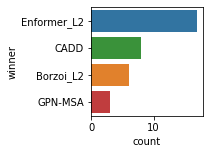

In [7]:
plt.figure(figsize=(2,2))
sns.countplot(
    data=wins,
    y="winner",
    order=wins.groupby("winner").trait.count().sort_values(ascending=False).index,
    palette=palette,
)

In [8]:
wins[wins.winner=="GPN-MSA"]

,trait,winner,n_hits
4,BMI,GPN-MSA,57
9,ECOL,GPN-MSA,17
18,Height,GPN-MSA,372


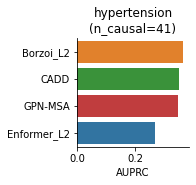

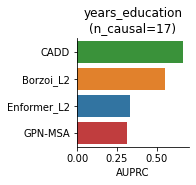

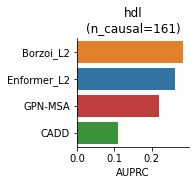

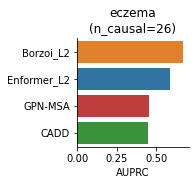

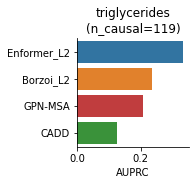

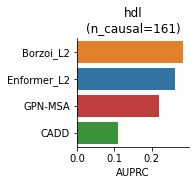

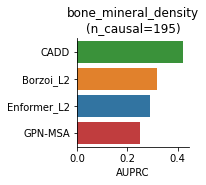

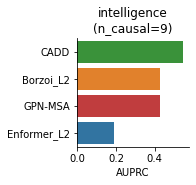

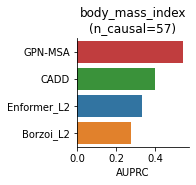

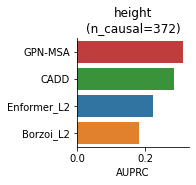

In [16]:
for trait in df.trait.sample(n=10, random_state=42):
    plt.figure(figsize=(2,2))
    g = sns.barplot(
        data=df[df.trait==trait],
        y="Model",
        x="AUPRC",
        order=df[df.trait==trait].sort_values("AUPRC", ascending=False).Model,
        palette=palette,
    )
    g.set(
        ylabel="",
        title=trait_renaming[trait] + f"\n(n_causal={n_hits[trait]})",
    )
    sns.despine();
    plt.show()